## Importing libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp
device=torch.device('cuda')

pyarrow not available, switching to pickle. To install pyarrow, run `pip install pyarrow`.
lz4 not available, disabling compression. To install lz4, run `pip install lz4`.
wandb not available, to install wandb, run `pip install wandb`.


In [4]:
torch.cuda.memory_allocated() * 1e-9

0.0

## Helper functions and classes

In [5]:
from utils.rle_utils import  get_img, rle_decode, make_mask, mask2rle, heightwidthchannel_to_channelheightwidth

In [6]:
from metrics.dice import dice

In [7]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(320, 640),
        albu.HorizontalFlip(p=0.25),
        albu.VerticalFlip(p=0.25),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0)
#         albu.GridDistortion(p=0.5),
#         albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),

    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=heightwidthchannel_to_channelheightwidth,
                    mask=heightwidthchannel_to_channelheightwidth),
    ]
    return albu.Compose(_transform)

## Data overview

Let's have a look at the data first.

In [8]:
path = '../input/understanding_cloud_organization'
img_paths = '../input/understanding-clouds-resized'
os.listdir(path)

['train.csv', 'sample_submission.csv', 'train_images', 'test_images']

We have folders with train and test images, file with train image ids and masks and sample submission.

In [9]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [10]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [11]:
n_train = len(os.listdir(f'{img_paths}/train_images_525/train_images_525'))
n_test = len(os.listdir(f'{img_paths}/test_images_525/test_images_525'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


So we have ~5.5k images in train dataset and they can have up to 4 masks: Fish, Flower, Gravel and Sugar.

In [12]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

Let's have a look at the images and the masks.

We can see that masks can overlap. Also we can see that clouds are really similar to fish, flower and so on. Another important point: masks are often quite big and can have seemingly empty areas.

## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

## Setting up data for training in Catalyst

In [13]:
from dataloaders.cloud_dataset_with_priors import CloudDatasetWithPriors

Now we define model and training parameters

In [14]:
torch.cuda.memory_allocated() * 1e-9

0.0

In [15]:
def preprocessing(image, mask):
    mean = np.array([0.485, 0.456, 0.406])[:, None, None] * 255
    std = np.array([0.229, 0.224, 0.225])[:, None, None] * 255
    image = (image.transpose(2,1,0) - mean) / std
    mask = mask.transpose(2,1,0) * 1.
    return {'image': image.astype(np.float32), 'mask': mask.astype(np.float32)}

In [16]:
def get_loader(train_img_fns, val_img_fns):
    num_workers = 1
    bs = 8
    train_dataset = CloudDatasetWithPriors(df=train,
                                 data_folder=f"{img_paths}/train_images_525/train_images_525",
                                 priors_folder='../weights/efficientnetb2/masks_oof_postprocessed/',          
                                 image_filenames=train_img_fns, 
                                 transforms = get_training_augmentation(), 
                                 preprocessing=preprocessing)
    valid_dataset = CloudDatasetWithPriors(df=train, 
                                 data_folder=f"{img_paths}/train_images_525/train_images_525",
                                 priors_folder='../weights/efficientnetb2/masks_oof_postprocessed/',
                                 image_filenames=val_img_fns, 
                                 transforms = get_validation_augmentation(), 
                                 preprocessing=preprocessing)

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

    return train_loader, valid_loader

In [17]:
torch.cuda.memory_allocated() * 1e-9

0.0

In [18]:
#model.load_state_dict(torch.load(logdir + 'best_full.pth')['model_state_dict'])

## Model training

In [19]:
from utils.nn_utils import seed_everything, eval, fit, count_parameters, cpu_unravel, gpu_unravel

In [20]:
from callbacks.callbacks import PrinterCallback, ModelCheckpoint

In [21]:
#for x,y in train_loader:
#    break

In [22]:
#count_parameters(model) # 19 047 918

In [23]:
from sklearn.model_selection import StratifiedKFold

id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
k_fold = StratifiedKFold(n_splits=5, random_state=0)

idxs = list(k_fold.split(id_mask_count['img_id'], id_mask_count['count']))
test_img_filenames = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [24]:
ENCODER = 'efficientnet-b2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None

In [25]:
# kernel split
#from sklearn.model_selection import StratifiedKFold
#train_idxs, valid_idxs = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=0).split(X=id_mask_count['img_id'].values,y=id_mask_count['count']))[0]

In [26]:
def parallelize(model):
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    return model

In [27]:
threshold = 0.65
min_pixel_size = 10_000

In [28]:
def encode(loader):
    encoded_pixels = []
    image_id = 0
    for i, test_batch in enumerate(tqdm.tqdm(loader)):
        runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
        for i, batch in enumerate(runner_out):
            for probability in batch:

                probability = probability.cpu().detach().numpy()
                if probability.shape != (350, 525):
                    probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0], class_params[image_id % 4][1])
                if num_predict == 0:
                    encoded_pixels.append('')
                else:
                    r = mask2rle(predict)
                    encoded_pixels.append(r)
                image_id += 1

In [29]:
from utils.modify_input_conv import modify_input_conv_efficientnet

In [51]:
for i, idx in enumerate(idxs):
#for i, idx in enumerate([[train_idxs, valid_idxs]]):
        
    seed_everything(0)

    train_idxs, val_idxs = idx
    train_img_fns = id_mask_count['img_id'].iloc[train_idxs].values
    val_img_fns = id_mask_count['img_id'].iloc[val_idxs].values

    model = smp.UnetPlus(
        encoder_name=ENCODER, 
        encoder_weights=None, 
        classes=4, 
        activation=ACTIVATION,
    )
    modify_input_conv_efficientnet(model, in_channels=7, image_size=[640, 320])
    
    weights = torch.load('../weights/efficientnetb2_with_masks/' + f'model_fold{i}.pth')
    new_weights = {}
    for key in weights:
        new_weights[key[7:]] = weights[key]
    model.load_state_dict(new_weights)
    
    model = model.cuda()
    
    loss_fn = smp.utils.losses.BCEDiceLoss(eps=1.)
    metrics = {'dice': dice}

    train_loader, valid_loader = get_loader(train_img_fns, val_img_fns)
    hist = eval(valid_loader,
                 model,
                 loss_fn=loss_fn,
                 return_logits=False,
                 metric_fns=metrics,
                 verbose=True,
                 batch_unravel_fn=gpu_unravel)
    print(hist)

Loaded pretrained weights for efficientnet-b2


139it [00:55,  2.49it/s]


{'metrics': {'dice': 0.5616857378320512}, 'val_loss': 0.7266130042161872, 'logits': None}
Loaded pretrained weights for efficientnet-b2


139it [00:48,  2.89it/s]


{'metrics': {'dice': 0.5483258078322986}, 'val_loss': 0.7427500992370166, 'logits': None}
Loaded pretrained weights for efficientnet-b2


139it [00:45,  3.09it/s]


{'metrics': {'dice': 0.574416993356989}, 'val_loss': 0.7092042432414541, 'logits': None}
Loaded pretrained weights for efficientnet-b2


139it [00:46,  3.00it/s]
/home/max/PycharmProjects/cloud_segmentation/src/metrics/dice.py:5: RuntimeWarning:

overflow encountered in exp



{'metrics': {'dice': 0.5616628500692576}, 'val_loss': 0.7183167792910294, 'logits': None}
Loaded pretrained weights for efficientnet-b2


139it [00:47,  2.93it/s]


{'metrics': {'dice': 0.560621402798186}, 'val_loss': 0.7295806886052056, 'logits': None}


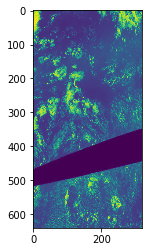

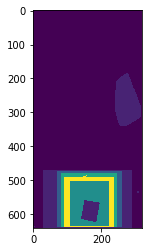

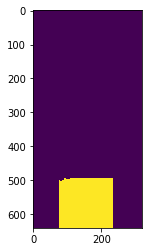

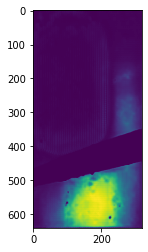

In [32]:
show_samples = True
if show_samples:
    for i, idx in enumerate(idxs):
        if i == 0 or i==1: continue
    #for i, idx in enumerate([[train_idxs, valid_idxs]]):

        seed_everything(0)

        train_idxs, val_idxs = idx
        train_img_fns = id_mask_count['img_id'].iloc[train_idxs].values
        val_img_fns = id_mask_count['img_id'].iloc[val_idxs].values
        train_loader, valid_loader = get_loader(train_img_fns, val_img_fns)
        break

    for x, y in valid_loader: break
        
    y_pred = torch.sigmoid(model(x.cuda())).cpu().detach().numpy()
    i=2
    j=2
    plt.imshow(x[i, j])
    plt.show()
    plt.imshow(x[i, j + 3])
    plt.show()
    plt.imshow(y[i, j])
    plt.show()
    plt.imshow(y_pred[i, j])

In [45]:
from postprocess.convert_to_rectangles import ProbabilityConverter

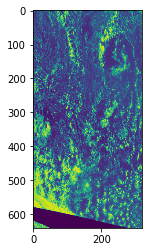

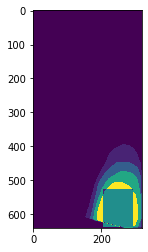

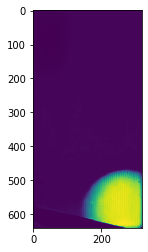

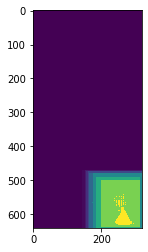

In [50]:
i=0
j=1
plt.imshow(x[i, j])
plt.show()
plt.imshow(x[i, j + 3])
plt.show()
plt.imshow(y_pred[i, j])
plt.show()
plt.imshow(ProbabilityConverter().convert_probability_to_multiple_bbox(y_pred[i, j]))
plt.show()